Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
data_path = "data/"
pickle_file = 'notMNIST.pickle'

with open(data_path+pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Let's start with the logistic model.

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, \
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # For the L2 loss
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, \
                                             num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          labels=tf_train_labels, logits=logits) + \
            beta_regul * tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + \
                                   biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, 
                 tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], \
                                    feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), \
                                                     valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 24.665695
Minibatch accuracy: 1.6%
Validation accuracy: 6.9%
Minibatch loss at step 500: 2.737254
Minibatch accuracy: 75.8%
Validation accuracy: 76.1%
Minibatch loss at step 1000: 1.975232
Minibatch accuracy: 75.8%
Validation accuracy: 78.2%
Minibatch loss at step 1500: 1.297055
Minibatch accuracy: 74.2%
Validation accuracy: 79.8%
Minibatch loss at step 2000: 1.140291
Minibatch accuracy: 76.6%
Validation accuracy: 80.7%
Minibatch loss at step 2500: 0.829868
Minibatch accuracy: 76.6%
Validation accuracy: 81.3%
Minibatch loss at step 3000: 0.673313
Minibatch accuracy: 85.9%
Validation accuracy: 82.1%
Test accuracy: 88.6%


The L2 regularization introduces a new meta parameter that should be tuned. Since I do not have any idea of what should be the right value for this meta parameter, I will plot the accuracy by the meta parameter value (in a logarithmic scale).

In [7]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            
            feed_dict = {tf_train_dataset: batch_data, \
                         tf_train_labels: batch_labels, beta_regul: regul}
            _, l, predictions = session.run([optimizer, \
                                             loss, train_prediction], \
                                                feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

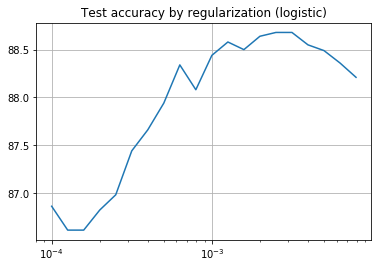

In [8]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title("Test accuracy by regularization (logistic)")
plt.show()

Let's see if the same technique will improve the prediction of the 1-layer neural network:

In [9]:
batch_size = 128
H = 1024

graph = tf.Graph()

with graph.as_default():
    
    # Input
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights_l1 = tf.Variable(tf.truncated_normal([image_size * image_size, H]))
    biases_l1 = tf.Variable(tf.zeros([H]))
    weights_l2 = tf.Variable(tf.truncated_normal([H, num_labels]))
    biases_l2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation
    train_l1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_l1) + biases_l1)
    logits = tf.matmul(train_l1, weights_l2) + biases_l2
    loss = tf.reduce_mean( \
        tf.nn.softmax_cross_entropy_with_logits( \
            logits=logits, labels=tf_train_labels)) + \
                beta_regul * (tf.nn.l2_loss(weights_l1) + \ 
                                  tf.nn.l2_loss(weights_l2))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Prediction for the training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    valid_l1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_l1) + biases_l1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_l1, weights_l2) + \
                                     biases_l2)
    test_l1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_l1) + biases_l1)
    test_prediction = tf.nn.softmax(tf.matmul(test_l1, weights_l2) + biases_l2)

SyntaxError: unexpected character after line continuation character (<ipython-input-9-49bbbdf8fb7a>, line 28)

In [ ]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,\ 
                 beta_regul : 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], \
                                    feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), \
                                                     valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

In [ ]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            
            feed_dict = {tf_train_dataset: batch_data, 
                         tf_train_labels: batch_labels, beta_regul: regul}
            _, l, predictions = session.run([optimizer, loss, \
                                             train_prediction], \ 
                                                feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

In [ ]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title("Test accuracy by regularization (logistic)")
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [ ]:
batch_size = 128
H = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input
    tf_train_dataset = tf.placeholder(tf.float32, \
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights_l1 = tf.Variable(tf.truncated_normal([image_size * image_size, H]))
    biases_l1 = tf.Variable(tf.zeros([H]))
    weights_l2 = tf.Variable(tf.truncated_normal([H, num_labels]))
    biases_l2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation
    train_l1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_l1) + biases_l1)
    logits = tf.matmul(train_l1, weights_l2) + biases_l2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( \
            logits=logits, labels=tf_train_labels)) + \
                beta_regul * (tf.nn.l2_loss(weights_l1) + \
                                  tf.nn.l2_loss(weights_l2))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Prediction for the training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    valid_l1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_l1) + biases_l1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_l1, weights_l2) + 
                                     biases_l2)
    test_l1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_l1) + biases_l1)
    test_prediction = tf.nn.softmax(tf.matmul(test_l1, weights_l2) + biases_l2)

In [ ]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = ((step % num_batches) * batch_size) % \
                (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, \
                 tf_train_labels : batch_labels, beta_regul : 0.0}
    _, l, predictions = session.run([optimizer, loss, train_prediction], \
                                    feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), \
                                                     valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Since there are far too much parameters and no regularization, the accuracy of the batches is 100%. The generalization capability is poor, as shown in the validation and test accuracy.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [ ]:
batch_size = 128
H = 1024

graph = tf.Graph()

with graph.as_default():
    
    # Input
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights_l1 = tf.Variable(tf.truncated_normal([image_size * image_size, H]))
    biases_l1 = tf.Variable(tf.zeros([H]))
    weights_l2 = tf.Variable(tf.truncated_normal([H, num_labels]))
    biases_l2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation
    train_l1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_l1) + biases_l1)
    drop1 = tf.nn.dropout(train_l1, 0.5)
    logits = tf.matmul(train_l1, weights_l2) + biases_l2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( \
            logits=logits, labels=tf_train_labels)) + \
                beta_regul * (tf.nn.l2_loss(weights_l1) + \
                                  tf.nn.l2_loss(weights_l2))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Prediction for the training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    valid_l1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_l1) + biases_l1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_l1, weights_l2) + 
                                     biases_l2)
    test_l1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_l1) + biases_l1)
    test_prediction = tf.nn.softmax(tf.matmul(test_l1, weights_l2) + biases_l2)

In [ ]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = ((step % num_batches) * batch_size) % \
                (train_labels.shape[0] - batch_size)
    #offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, \
                 tf_train_labels : batch_labels, beta_regul : 0.0}
    _, l, predictions = session.run([optimizer, loss, train_prediction], \
                                    feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), \
                                                     valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

There is no improvement, something is fishy...

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Let's use 2 layers, with a slightly different parameters inizialization

In [20]:
batch_size = 128
H1 = 1024
H2 = 512
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    
    # Input
    tf_train_dataset = tf.placeholder(tf.float32, \
                                     shape=(batch_size, \
                                            image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    # Variable
    weights_l1 = tf.Variable(tf.truncated_normal([image_size * image_size, H1],\
            stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases_l1 = tf.Variable(tf.zeros([H1]))
    weights_l2 = tf.Variable(tf.truncated_normal([H1, H2], \
            stddev=np.sqrt(2.0 / H1)))
    biases_l2 = tf.Variable(tf.zeros([H2]))
    weights_l3 = tf.Variable(tf.truncated_normal([H2, num_labels], \
            stddev=np.sqrt(2.0 / H2)))
    biases_l3 = tf.Variable(tf.zeros([num_labels]))
    
    # Training
    train_l1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_l1) + biases_l1)
    train_l2 = tf.nn.relu(tf.matmul(train_l1, weights_l2) + biases_l2)
    logits = tf.matmul(train_l2, weights_l3) + biases_l3
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, \
                                                labels=tf_train_labels) + \
        beta_regul * (tf.nn.l2_loss(weights_l1) + \
                      tf.nn.l2_loss(weights_l2) + \
                      tf.nn.l2_loss(weights_l3)))
    
    # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, \
                                               staircase=True)
    optimizer = tf.train.GradientDescentOptimizer( \
        learning_rate).minimize(loss,global_step=global_step)
    
    # Predictions
    
    train_prediction = tf.nn.softmax(logits)
    valid_l1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_l1) + biases_l1)
    valid_l2 = tf.nn.relu(tf.matmul(valid_l1, weights_l2) + biases_l2)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_l2, weights_l3) + \
                                     biases_l3)
    test_l1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_l1) + biases_l1)
    test_l2 = tf.nn.relu(tf.matmul(test_l1, weights_l2) + biases_l2)
    test_prediction = tf.nn.softmax(tf.matmul(test_l2, weights_l3) + biases_l3)

In [21]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate minibatch
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset: batch_data, \
                     tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], \
                                       feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, \
                                                        batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
              valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), \
                                             test_labels))

Initialized
Minibatch loss at step 0: 3.256059
Minibatch accuracy: 8.6%
Validation accuracy: 40.0%
Minibatch loss at step 500: 1.162595
Minibatch accuracy: 81.2%
Validation accuracy: 85.8%
Minibatch loss at step 1000: 0.900569
Minibatch accuracy: 84.4%
Validation accuracy: 86.7%
Minibatch loss at step 1500: 0.670577
Minibatch accuracy: 87.5%
Validation accuracy: 88.1%
Minibatch loss at step 2000: 0.786530
Minibatch accuracy: 85.9%
Validation accuracy: 88.5%
Minibatch loss at step 2500: 0.530741
Minibatch accuracy: 89.8%
Validation accuracy: 88.9%
Minibatch loss at step 3000: 0.456223
Minibatch accuracy: 91.4%
Validation accuracy: 89.2%
Minibatch loss at step 3500: 0.462923
Minibatch accuracy: 92.2%
Validation accuracy: 89.4%
Minibatch loss at step 4000: 0.616204
Minibatch accuracy: 87.5%
Validation accuracy: 89.7%
Minibatch loss at step 4500: 0.403161
Minibatch accuracy: 94.5%
Validation accuracy: 89.9%
Minibatch loss at step 5000: 0.505463
Minibatch accuracy: 89.1%
Validation accuracy

Can we improve? We should try dropout.